<a href="https://colab.research.google.com/github/azizamirsaidova/santander_customer_satisfaction/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Santander Customer Satisfaction

Team Members: Yashraj, Aziza, Jameel, Iniyan, Akshay


#### From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

#### In this project, we work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

#### The task is to predict the probability of each customer in the test set being unsatisfied.

#### Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression, lasso_path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from imblearn.over_sampling import SMOTE
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBClassifier

from collections import Counter
from IPython.display import clear_output
from warnings import filterwarnings
from sklearn.metrics import make_scorer

filterwarnings(action='ignore')
clear_output()

plt.style.use('fivethirtyeight')

In [3]:
#Connecting to GDrive

# from google.colab import drive
# drive.mount('/gdrive')
# !unzip /gdrive/MyDrive/data/santander-customer-satisfaction.zip

# clear_output()
# !ls

## Preprocessing and Cleaning of the data

In [4]:
# Reading data
data = pd.read_csv('train.csv')

data.drop('ID', axis=1, inplace=True)
data.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
#Yay! No nulls
data.isnull().any().any()

False

In [6]:
#Splitting data
X, y = data.drop('TARGET', axis=1), data['TARGET']
Xtrain, Xval, ytrain, yval = train_test_split(X, y, stratify=y, train_size=.8)
print(Xtrain.shape, ytrain.shape)
print(Xval.shape, yval.shape)

(60816, 369) (60816,)
(15204, 369) (15204,)


## Data Imbalance

In [7]:
ytrain.value_counts()

0    58410
1     2406
Name: TARGET, dtype: int64

We see our data is highly imbalanced, around 96% of data belongs to class 0. So that means if we had a model which always predicted 0, we would have 96% accuracy. Obviously, accuracy is not a very good metric in such cases, we'll use other metrics like f1 score, auc score, etc. to evaluate our model

But first things first, we'll use SMOTE to upsample minority class and have equal distribution of classes in train set. Doing so makes sure that our model is less biased towards majority class.

SMOTE is an improvement over minority oversampling. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

##  Before SMOTE
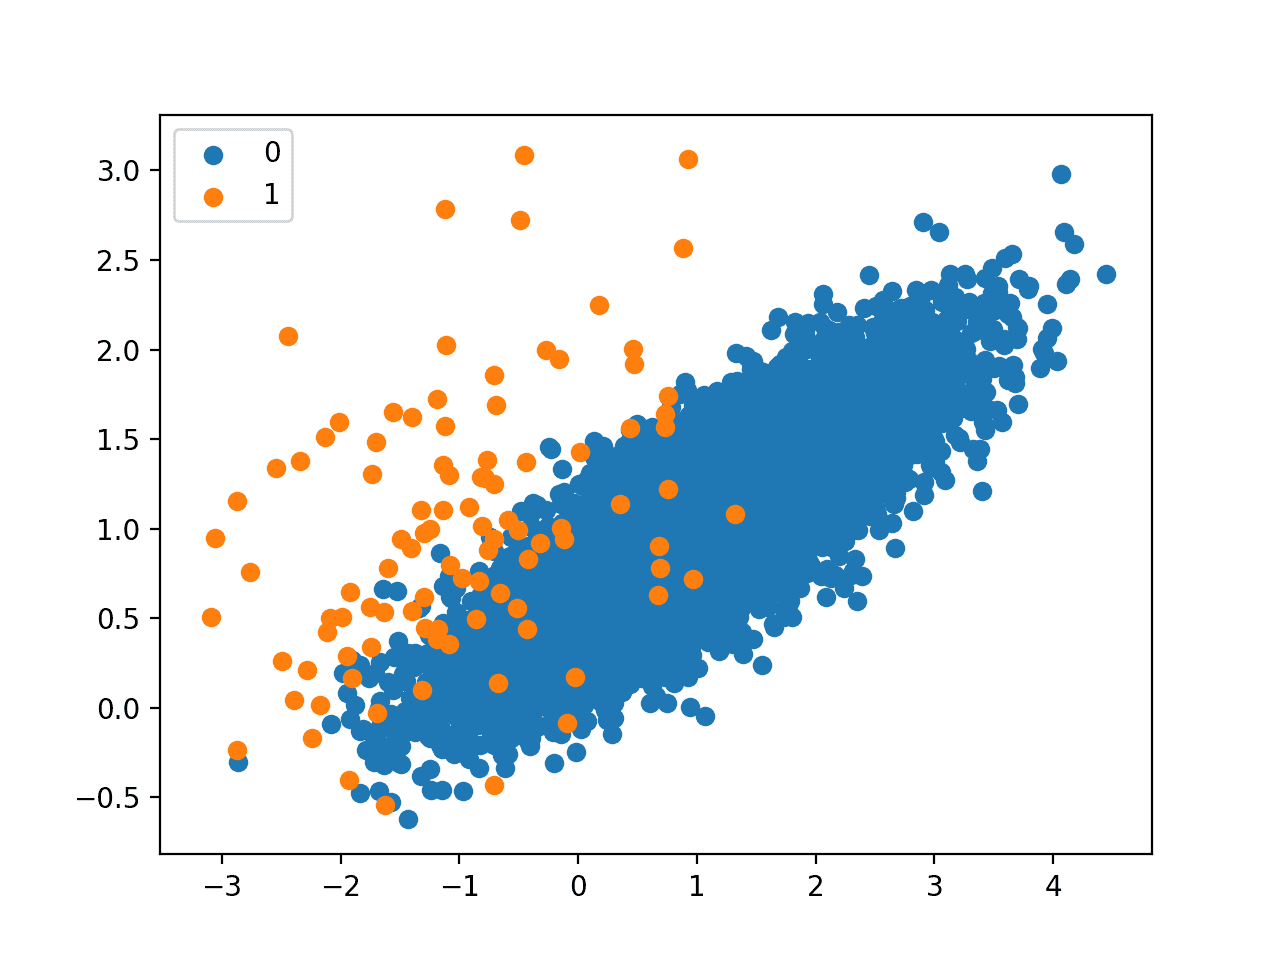


## After SMOTE

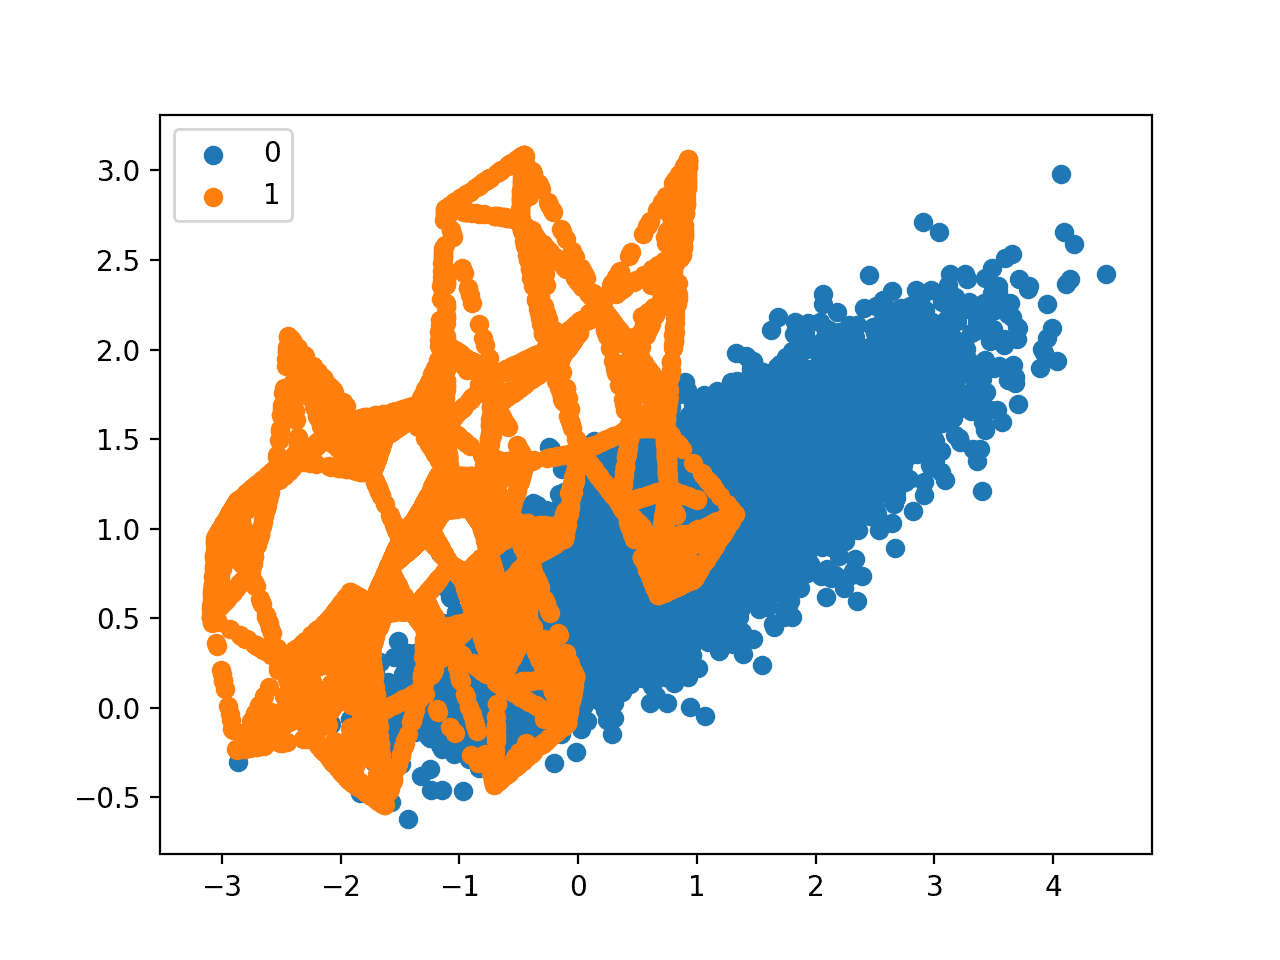



ref : https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [8]:
# Upsampling using SMOTE to deal with data imbalance
oversample = SMOTE()
Xtrain_new, ytrain_new = oversample.fit_resample(Xtrain, ytrain)

# summarize class distribution
print("Before SMOTE", Counter(ytrain), sep='\n')
print("\nAfter SMOTE", Counter(ytrain_new), sep='\n')

Before SMOTE
Counter({0: 58410, 1: 2406})

After SMOTE
Counter({0: 58410, 1: 58410})


## Eliminating Collinearities

> As we have a lot of features we will have to eliminate those with high collinearities, we should be very careful while doing. Here we have 369 features, around 100 of those (by inspection) are constant or quasi-constant. 

> We will use lasso path to eliminate variables for us.



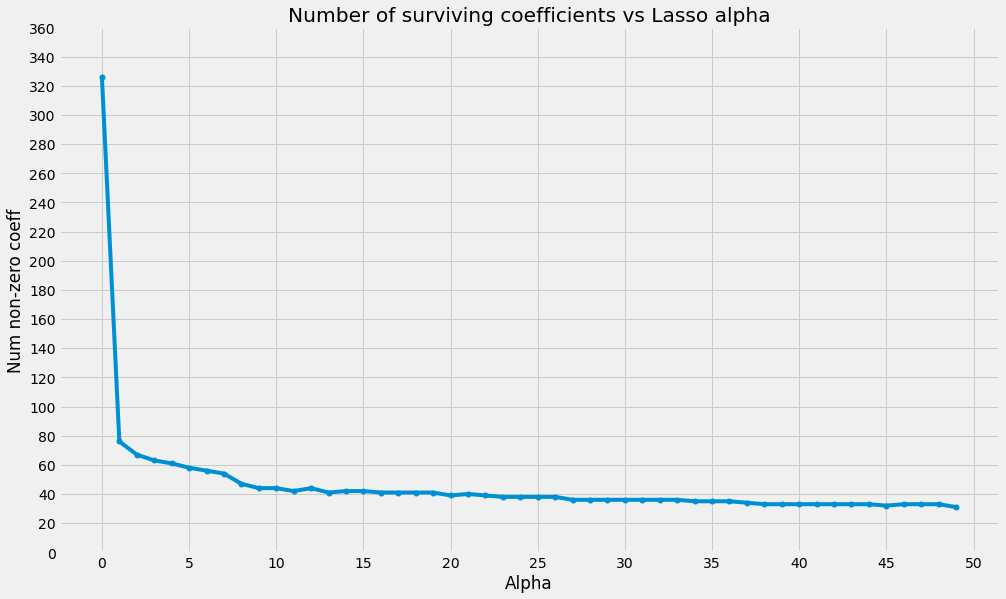

In [9]:
#Using lasso to redue number of variables by eliminating correlations

alphas, coef, dual_gaps = lasso_path(Xtrain_new, ytrain_new, alphas=range(0,50))

num_coef = []
for i in range(len(alphas)):
    remaining_coef = (coef[:, i] != 0).sum()
    num_coef.append(remaining_coef)

plt.figure(figsize=(15, 9))
ax = plt.gca()
ax.plot(alphas, num_coef, '-o', ms=5)
_ = ax.set(xlabel='Alpha', ylabel='Num non-zero coeff', title="Number of surviving coefficients vs Lasso alpha",
       yticks=range(0,380,20), xticks=range(0,51,5))


(116820, 61)


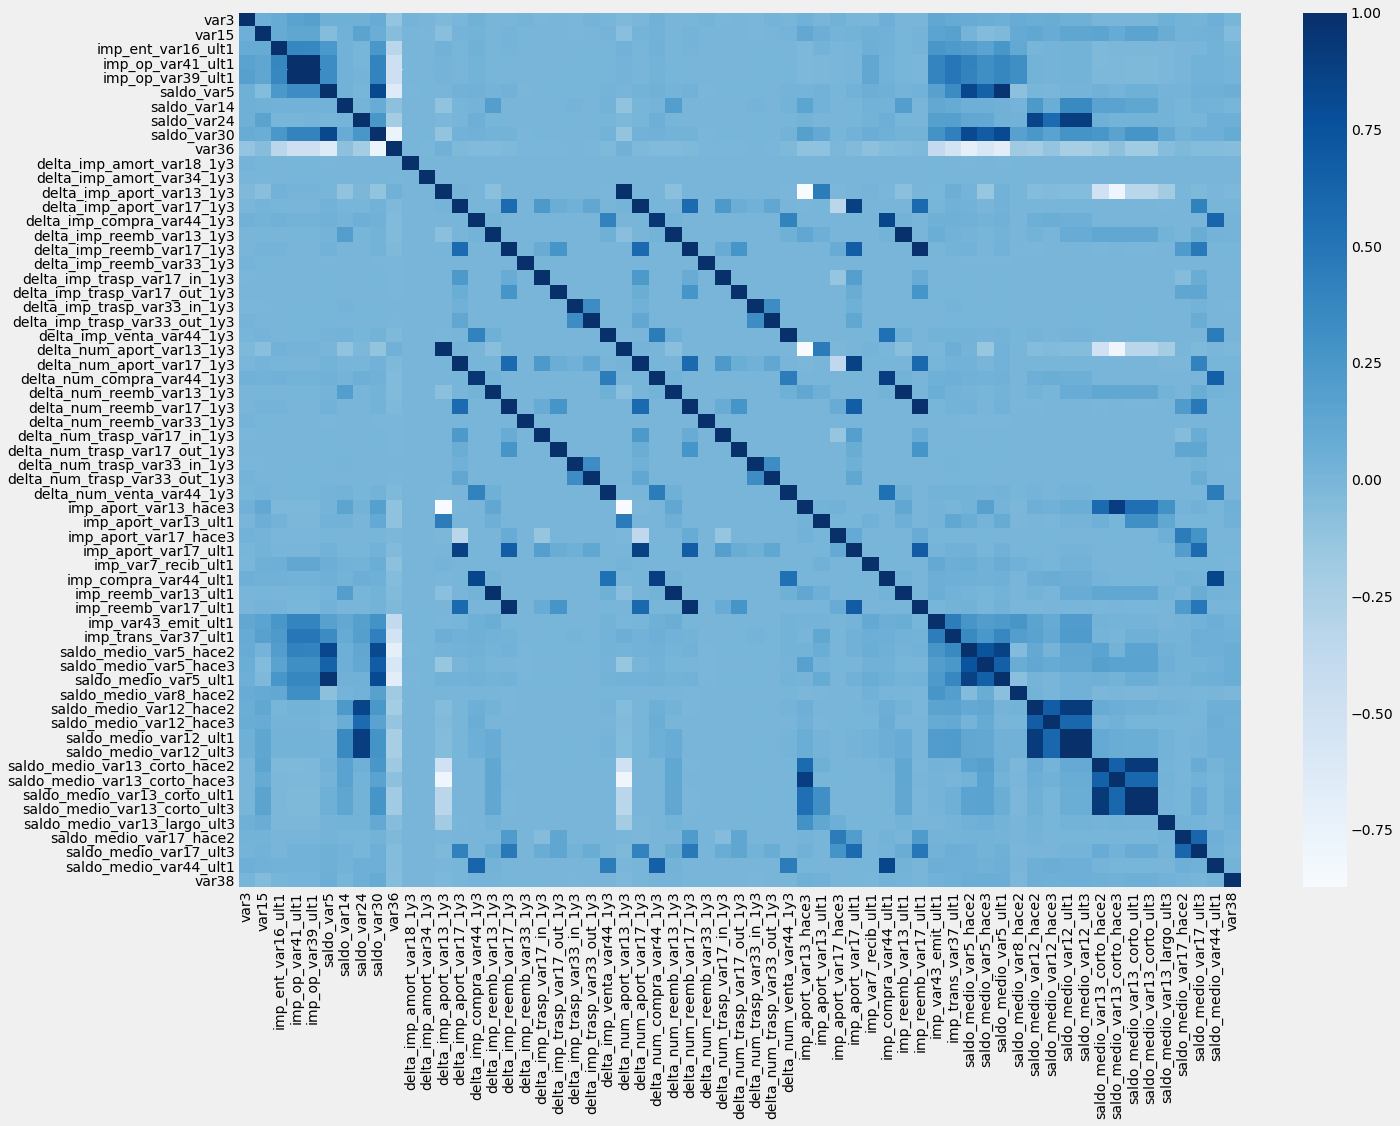

In [10]:
lasso_mask = (coef[:, -5] != 0)     #lasso alpha chosen by validation
lasso_cols = Xtrain.columns[lasso_mask]

Xtrain_lasso = pd.DataFrame(Xtrain_new[:, lasso_mask], columns=lasso_cols)
Xval_lasso = Xval[lasso_cols]

print(Xtrain_lasso.shape)

plt.figure(figsize=(20,15))
sns.heatmap(Xtrain_lasso.corr(method='spearman'), cmap='Blues')

Although lasso has eliminated most of collinear features we still see some high correlations in the heatmap. We are going to keep them for now as we cannot always eliminate all correlations without losing a significant amount of information.

To verify that we are not losing a lot of information we fit non-trivial models. First on all data and second on lasso selected columns.

In [11]:
def fit_model(estimator, Xtrain, ytrain, Xval, yval, fig_title=''):
    """
    Fits estimator and report various scores on validation set.
    Returns:
        fitted estimator
    """
    #Fit model
    estimator.fit(Xtrain, ytrain)

    #Predict on train and val
    train_pred = estimator.predict(Xtrain)
    val_pred = estimator.predict(Xval)
    #Report Accuracy
    print(f"Train Accuracy: {metrics.accuracy_score(ytrain, train_pred):.3f}")
    print(f"  Val Accuracy: {metrics.accuracy_score(yval, val_pred):.3f}")
    #Classification Report
    print("\n=============== Classification Report ===============")
    print(classification_report(yval, val_pred))

    #Confusion matirx and ROC curve
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    sns.heatmap(confusion_matrix(yval, val_pred)/yval.shape[0], annot=True, cmap="Blues", ax=ax[0])
    ax[0].set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

    metrics.plot_roc_curve(estimator, Xval, yval, ax=ax[1])
    ax[1].set(title='ROC Curve for '+str(estimator).split('(')[0])

    fig.suptitle(fig_title, fontweight='bold', size=20)
    #fig.tight_layout()

    return estimator

Train Accuracy: 0.925
  Val Accuracy: 0.892

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     14602
           1       0.17      0.43      0.24       602

    accuracy                           0.89     15204
   macro avg       0.57      0.67      0.59     15204
weighted avg       0.94      0.89      0.91     15204



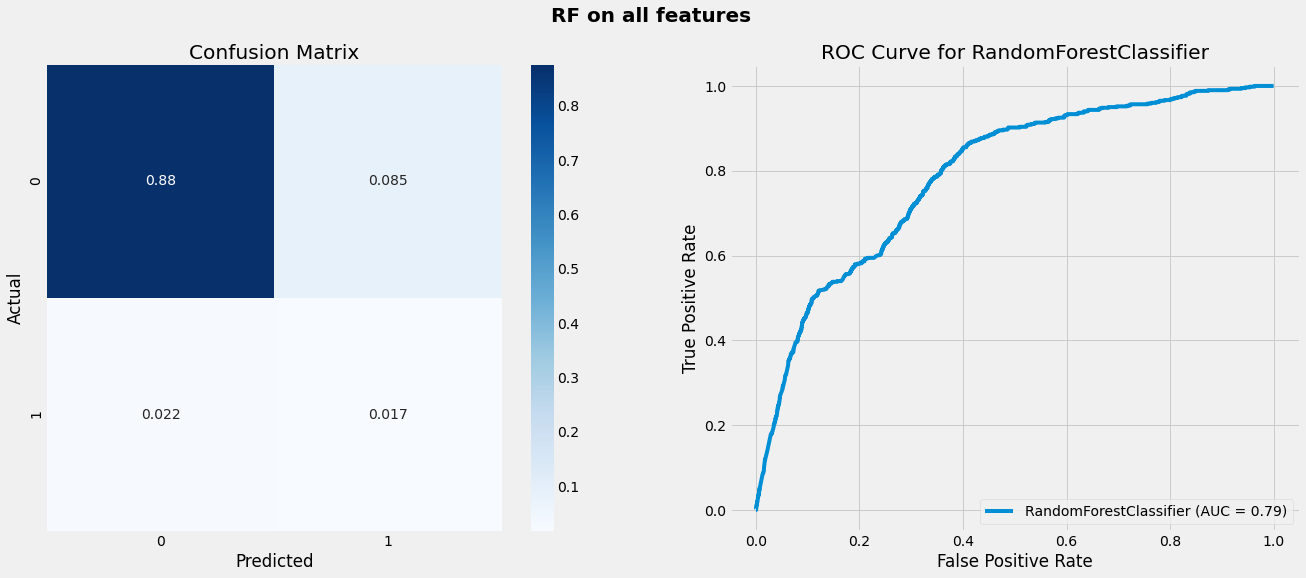

In [12]:
# Training random forest on All features
rf1 = RandomForestClassifier(n_jobs=-1, min_samples_leaf=10,
                            max_depth=20, n_estimators=300)

rf1 = fit_model(rf1, Xtrain_new, ytrain_new, Xval, yval,
                fig_title='RF on all features')

Train Accuracy: 0.892
  Val Accuracy: 0.863

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.98      0.88      0.92     14602
           1       0.15      0.54      0.24       602

    accuracy                           0.86     15204
   macro avg       0.57      0.71      0.58     15204
weighted avg       0.95      0.86      0.90     15204



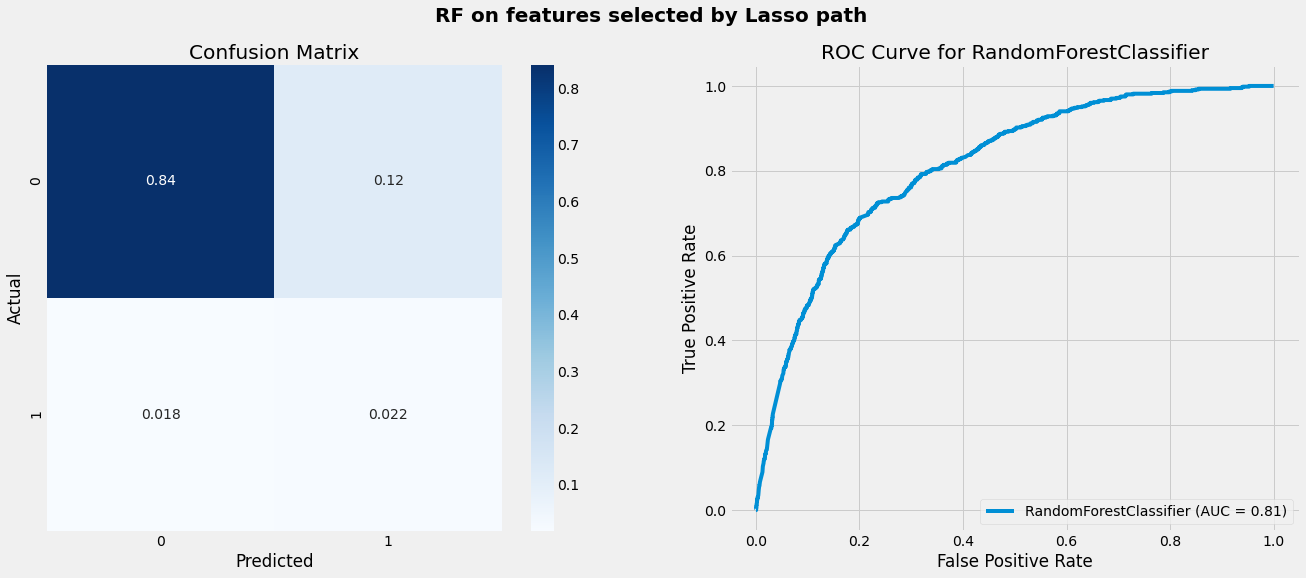

In [13]:
# Training random forest on features selected by Lasso path
rf2 = RandomForestClassifier(n_jobs=-1, min_samples_leaf=10,
                            max_depth=20, n_estimators=300)

rf2 = fit_model(rf2, Xtrain_lasso, ytrain_new, Xval_lasso, yval,
               fig_title='RF on features selected by Lasso path')

Model trained on Lasso features has accuracy a little lower than model trained on all features. But Lasso model outperforms other model in f1 score and auc score. 

Model trained on Lasso features is definitely the better model here.

## EDA 

> We have selected features using Lasso, now let's see whats happening in them.



In [14]:
# We still have about 70 features so we'll only look at most important features 
# selected by SelectKBest

best = 8
sel = SelectKBest(k=best)
sel.fit(Xtrain_lasso, ytrain_new)
X_plot = Xtrain_lasso.loc[:, sel.get_support()]
X_plot['target'] = ytrain_new

# Sampling to reduce size for computational reasons
X_plot = X_plot.sample(n=10000)
X_plot.shape

(10000, 9)

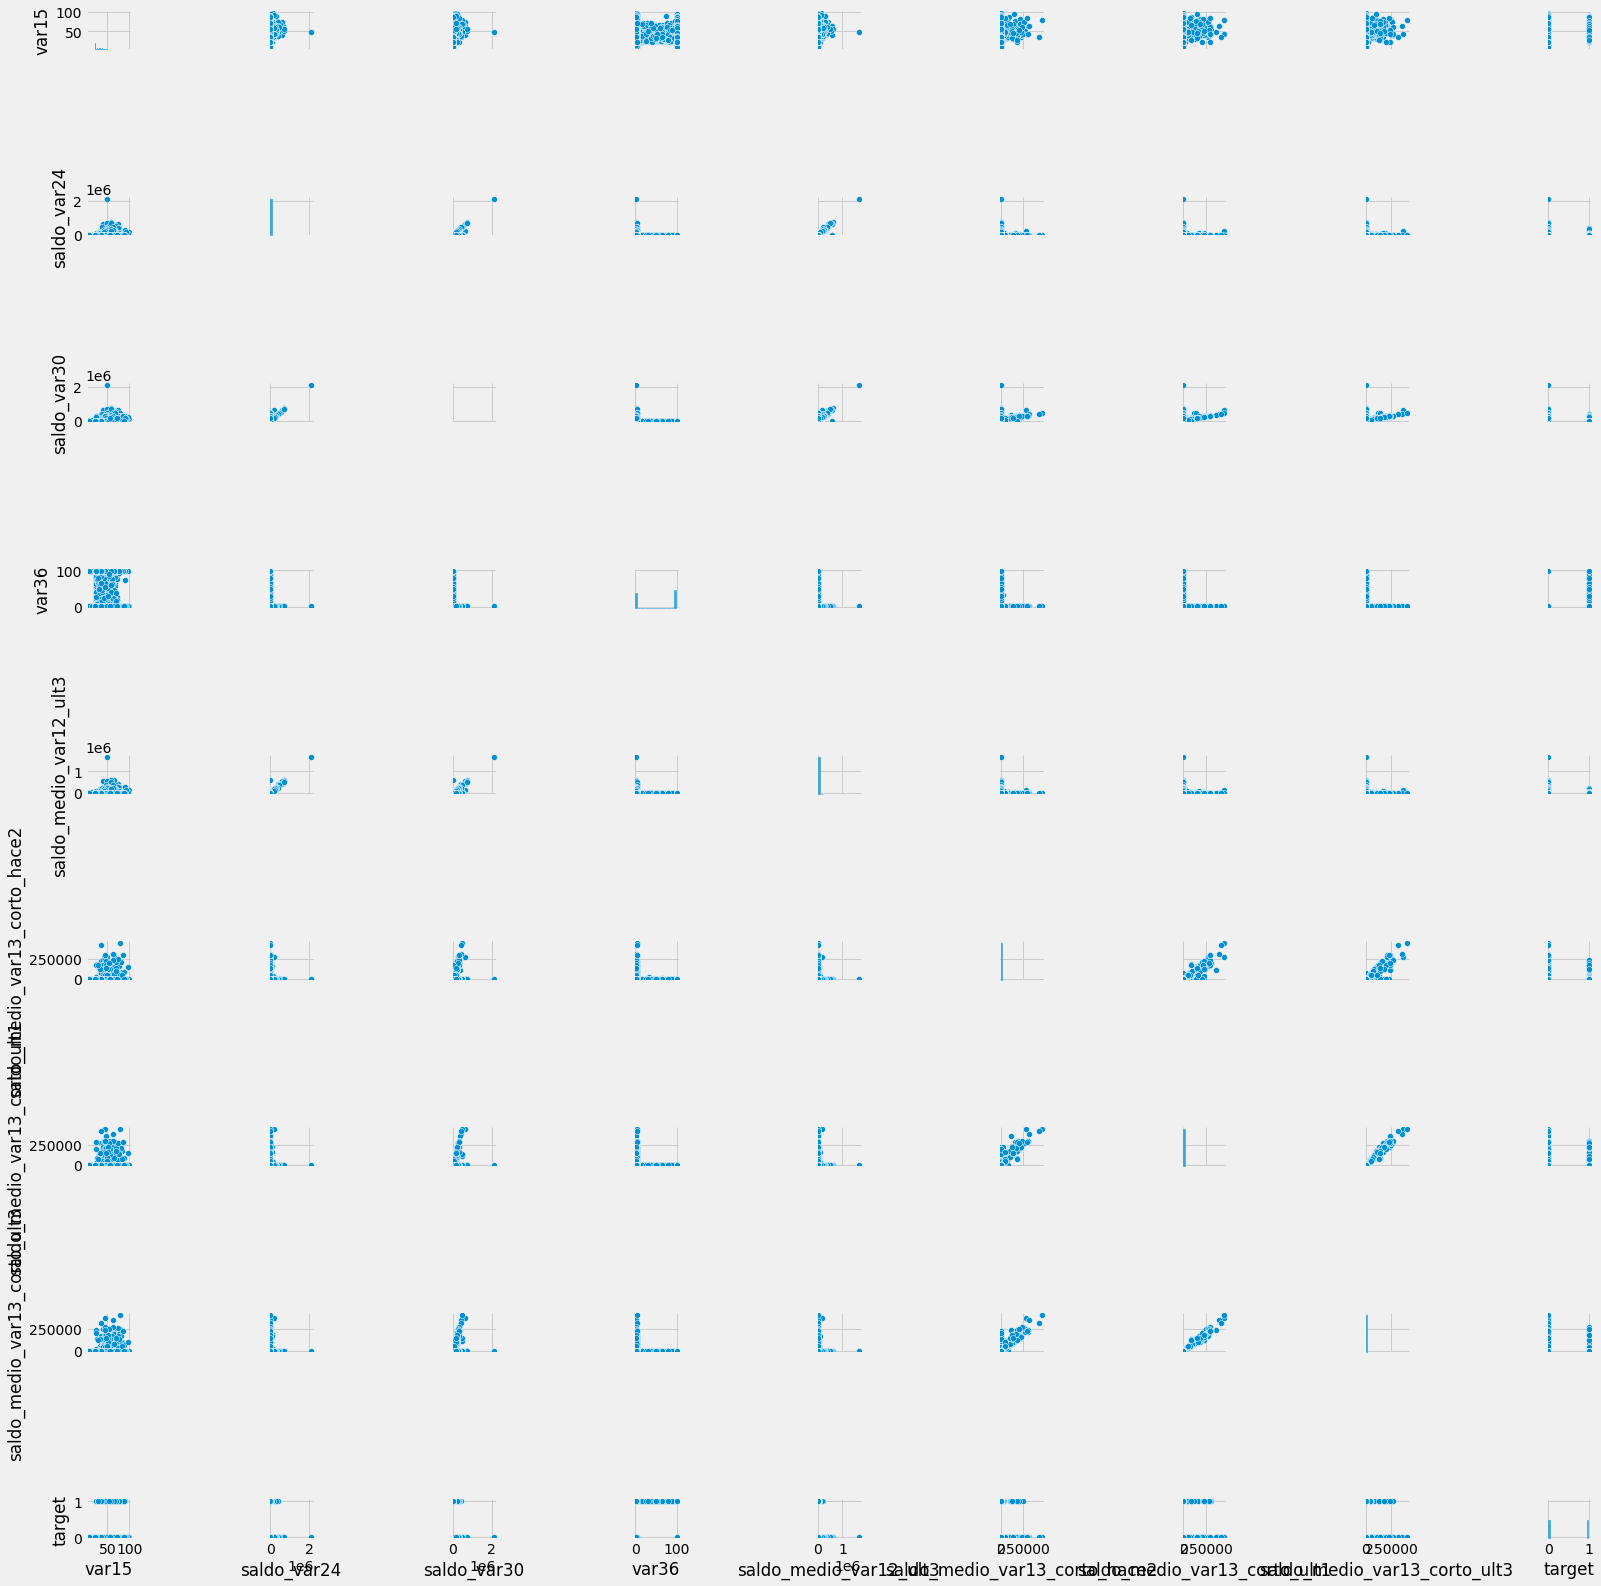

In [29]:
#Pair plot to see relations between variables
sns.pairplot(data=X_plot)

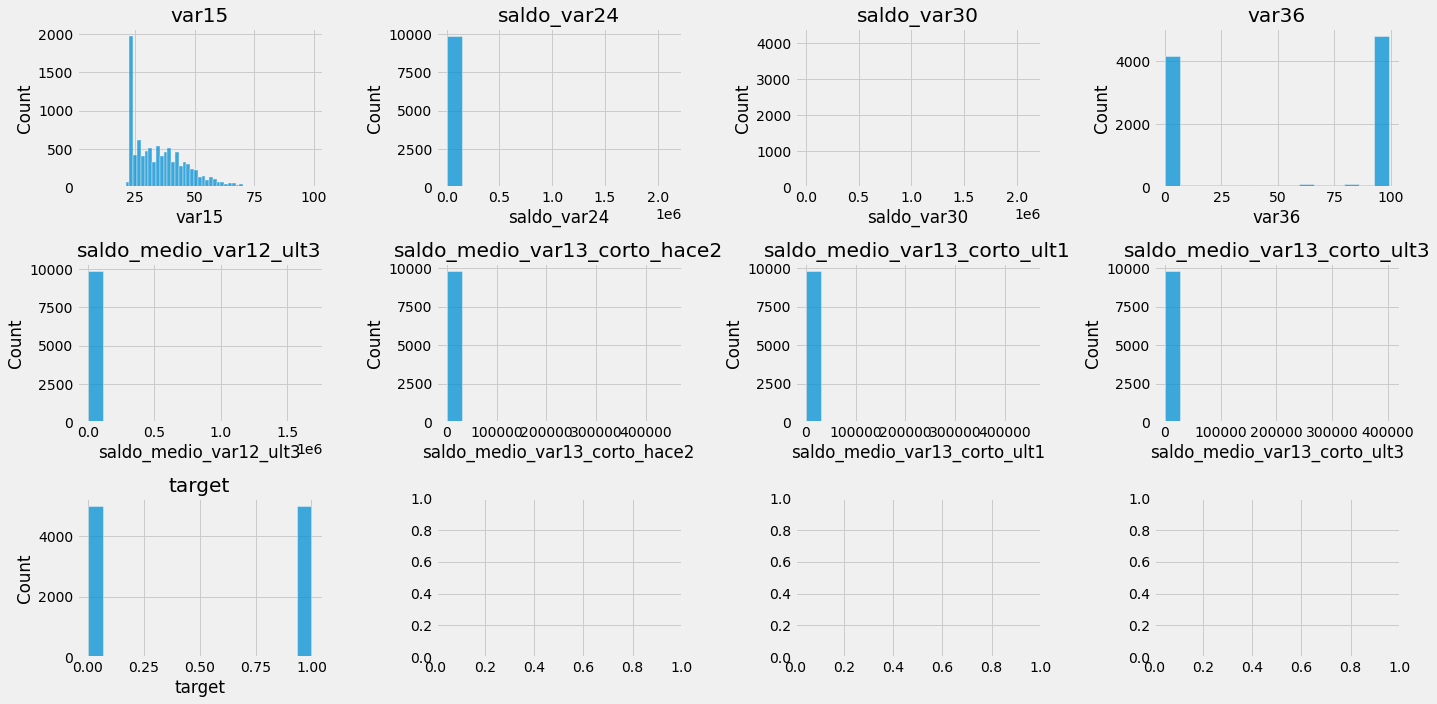

In [16]:
# Distrbution Plots

ncols = 4
nrows = int(np.ceil(X_plot.shape[1]/ncols))

fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
ax = ax.ravel()

for i, col in enumerate(X_plot.columns):
    sns.histplot(X_plot[col], ax=ax[i])#.set(xscale='log')
    ax[i].set(title=col)

fig.tight_layout()
plt.show()

We see this is a highly asymmetric dataset. Most variables are 0 inflated. Var15 has almost Poisson distribution

## Base Model

Train Accuracy: 0.96
  Val Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14602
           1       0.00      0.00      0.00       602

    accuracy                           0.96     15204
   macro avg       0.48      0.50      0.49     15204
weighted avg       0.92      0.96      0.94     15204



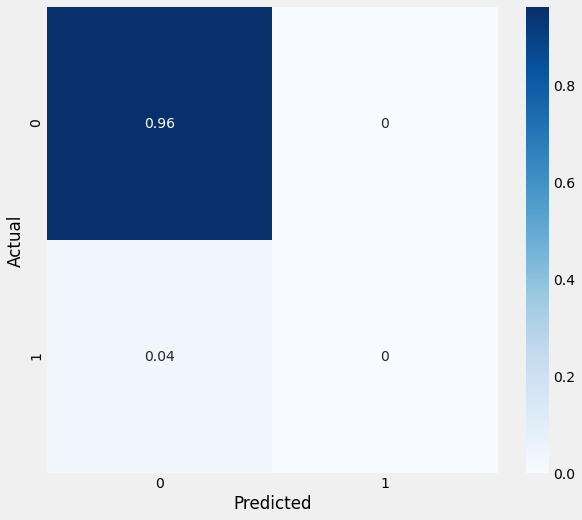

In [17]:
#Naive Baseline Model

ytrain_pred_naive = [False]*ytrain.shape[0]
yval_pred_naive = [False]*yval.shape[0]

print(f"Train Accuracy: {metrics.accuracy_score(ytrain, ytrain_pred_naive):.2f}")
print(f"  Val Accuracy: {metrics.accuracy_score(ytrain, ytrain_pred_naive):.2f}")

plt.figure(figsize=(9,8))
sns.heatmap(confusion_matrix(yval, yval_pred_naive)/yval.shape[0], annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
print(classification_report(yval, yval_pred_naive))

Train Accuracy: 0.851
  Val Accuracy: 0.848

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     14602
           1       0.13      0.52      0.21       602

    accuracy                           0.85     15204
   macro avg       0.56      0.69      0.56     15204
weighted avg       0.94      0.85      0.89     15204



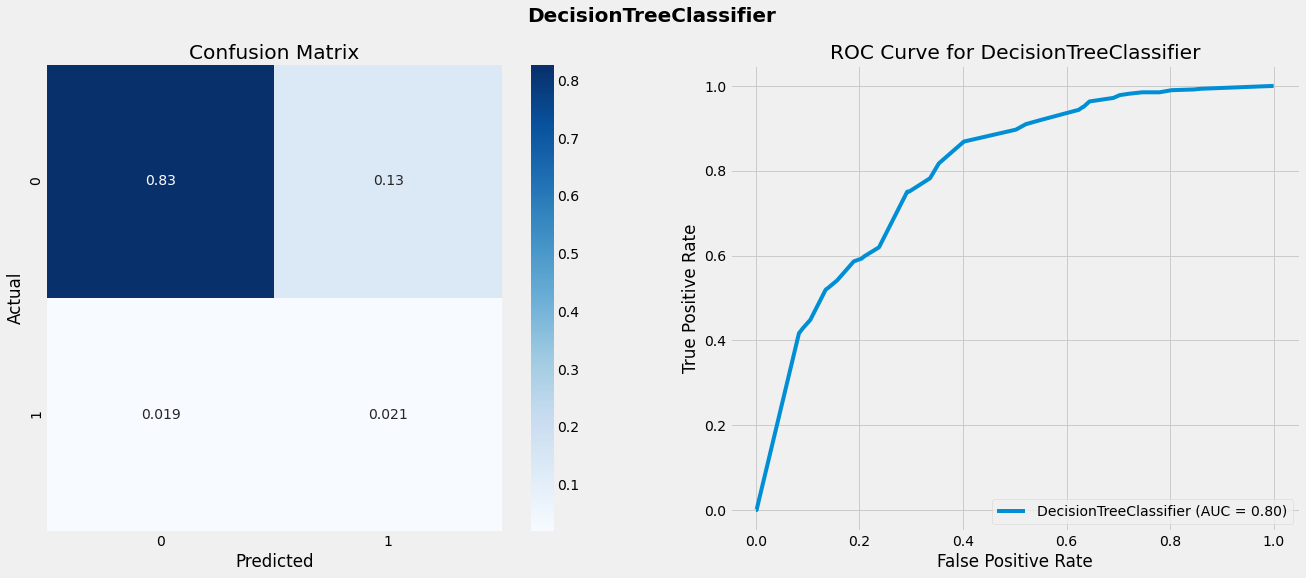

In [18]:
dtree = DecisionTreeClassifier(max_depth=6, criterion='entropy', splitter='best',
                                                         min_samples_leaf=50)


dtree = fit_model(dtree, Xtrain_lasso, ytrain_new, Xval_lasso, yval,
                fig_title='DecisionTreeClassifier')

Train Accuracy: 0.500
  Val Accuracy: 0.960

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14602
           1       0.00      0.00      0.00       602

    accuracy                           0.96     15204
   macro avg       0.48      0.50      0.49     15204
weighted avg       0.92      0.96      0.94     15204



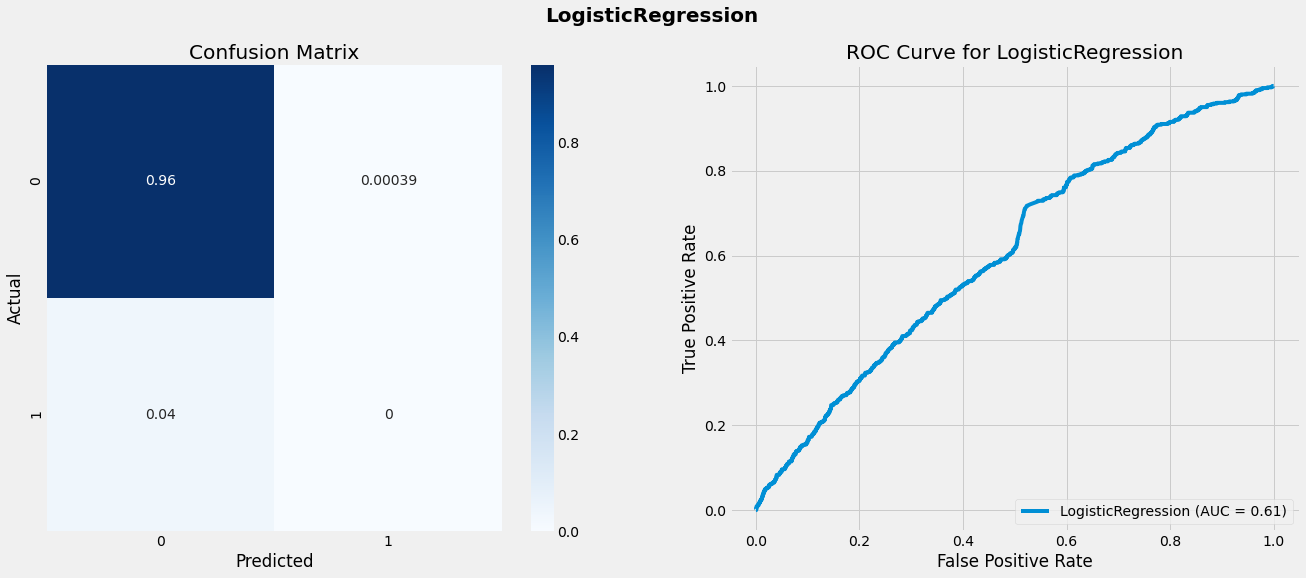

In [19]:
logreg = LogisticRegression(n_jobs=-1, C=1.)
logreg = fit_model(logreg, Xtrain_lasso, ytrain_new, Xval_lasso, yval,
                fig_title='LogisticRegression')

Very Naive Model has accuracy of 96% and F1 score of 0.00.

Decision Tree has accuracy of 82% and ROC-AUC score of 0.78.

Logistic Regression has accuracy of 96% and ROC-AUC score of 0.61, it performs unusually worse than DecisionTree.


Very Naive outperforms DecisionTree in terms of accuracy. But as we have high data imbalance, accuracy is not the best metric to use. 

Decision Tree outperforms Naive Model in terms of F1 score. 





## Ensemble Models

Train Accuracy: 0.892
  Val Accuracy: 0.862

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     14602
           1       0.15      0.54      0.24       602

    accuracy                           0.86     15204
   macro avg       0.57      0.71      0.58     15204
weighted avg       0.95      0.86      0.90     15204



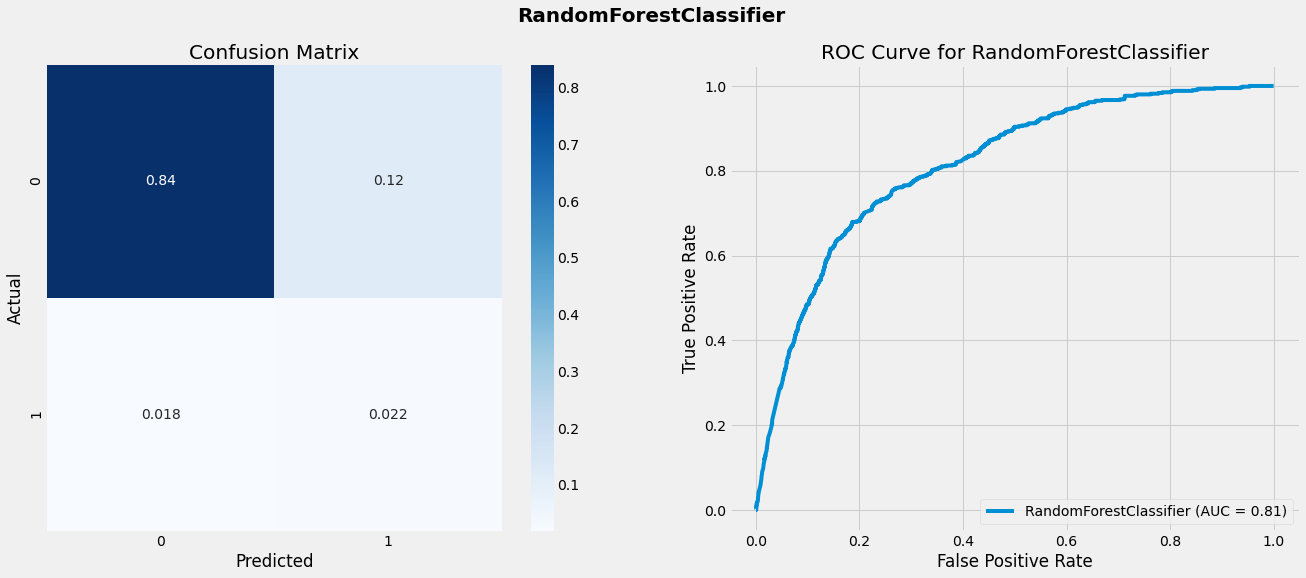

In [20]:
rf = RandomForestClassifier(n_jobs=-1, min_samples_leaf=10,
                            max_depth=20, n_estimators=300)

rf = fit_model(rf, Xtrain_lasso, ytrain_new, Xval_lasso, yval,
               fig_title='RandomForestClassifier')

Train Accuracy: 0.880
  Val Accuracy: 0.850

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     14602
           1       0.15      0.57      0.23       602

    accuracy                           0.85     15204
   macro avg       0.56      0.72      0.57     15204
weighted avg       0.95      0.85      0.89     15204



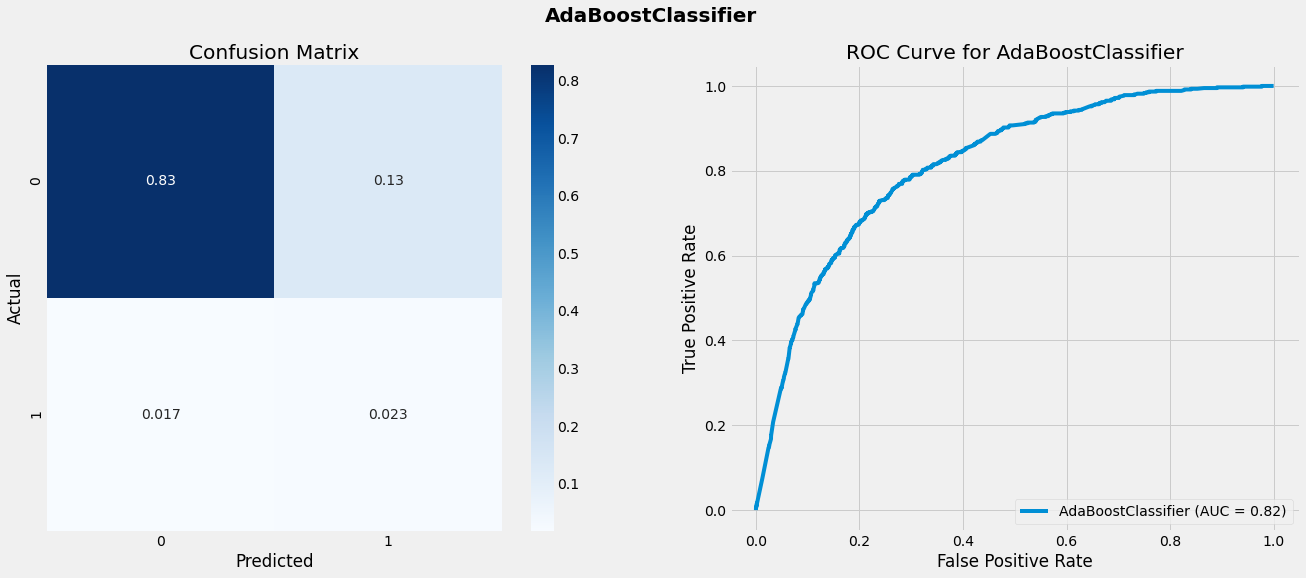

In [21]:
adaboost = AdaBoostClassifier(n_estimators=200,learning_rate=1)

adaboost = fit_model(adaboost, Xtrain_lasso, ytrain_new, Xval_lasso, yval,
               fig_title='AdaBoostClassifier')

Ensemble models perform better than our base models. RandomForest ourperforms Adaboost by a very small margin.

## Model Comparison 

In [22]:
yval_pred_dtree = dtree.predict(Xval_lasso)
yval_pred_rf = rf.predict(Xval_lasso)
yval_pred_ab = adaboost.predict(Xval_lasso)
yval_pred_lr = logreg.predict(Xval_lasso)

models_scores_table = pd.DataFrame({'Very Naive Model':[metrics.accuracy_score(yval, yval_pred_naive),
                                                       precision_score(yval, yval_pred_naive),  
                                                      recall_score(yval, yval_pred_naive),
                                                      f1_score (yval, yval_pred_naive)],
                                                                                    
                                  'Decision Tree':[metrics.accuracy_score(yval, yval_pred_dtree),
                                                  precision_score(yval, yval_pred_dtree),  
                                                  recall_score(yval, yval_pred_dtree),
                                                  f1_score (yval, yval_pred_dtree)],
                                    
                                  'Random Forest':[metrics.accuracy_score(yval, yval_pred_rf),
                                                  precision_score(yval, yval_pred_rf),  
                                                  recall_score(yval, yval_pred_rf),
                                                  f1_score (yval, yval_pred_rf)],
                                  'Adaboost':[metrics.accuracy_score(yval, yval_pred_ab),
                                                  precision_score(yval, yval_pred_ab),  
                                                  recall_score(yval, yval_pred_ab),
                                                  f1_score (yval, yval_pred_ab)],
                                    
                                    'Logistic Regression':[metrics.accuracy_score(yval, yval_pred_lr),
                                                  precision_score(yval, yval_pred_lr),  
                                                  recall_score(yval, yval_pred_lr),
                                                  f1_score (yval, yval_pred_lr)],
                                    },
                                   
                                  index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)

models_scores_table

,Very Naive Model,Decision Tree,Random Forest,Adaboost,Logistic Regression,Best Score
Accuracy,0.960405,0.847803,0.861681,0.850105,0.960011,Very Naive Model
Precision,0.000000,0.134500,0.152063,0.145455,0.000000,Random Forest
Recall,0.000000,0.523256,0.544850,0.571429,0.000000,Adaboost
F1 Score,0.000000,0.213995,0.237767,0.231884,0.000000,Random Forest


We'll proceed with random forest to do interpretation.

## Interpretation

In [23]:
# Define a function to get permutation importance
def plot_importance(cols, fi, fistd = 0, return_df = False, figsize=(15,10), top=-1, title=""):
    df =  pd.DataFrame({'features':cols, 'importance':fi, 'importance_std': fistd}
                       ).sort_values('importance', ascending=False)
    if top==-1 or top > df.shape[0]:
        top = df.shape
    
    plt.figure(figsize=figsize)
    sns.barplot(y='features', x='importance', data=df.head(top), xerr=df['importance_std'].head(top))
    plt.title(title)
    if return_df:
        return df

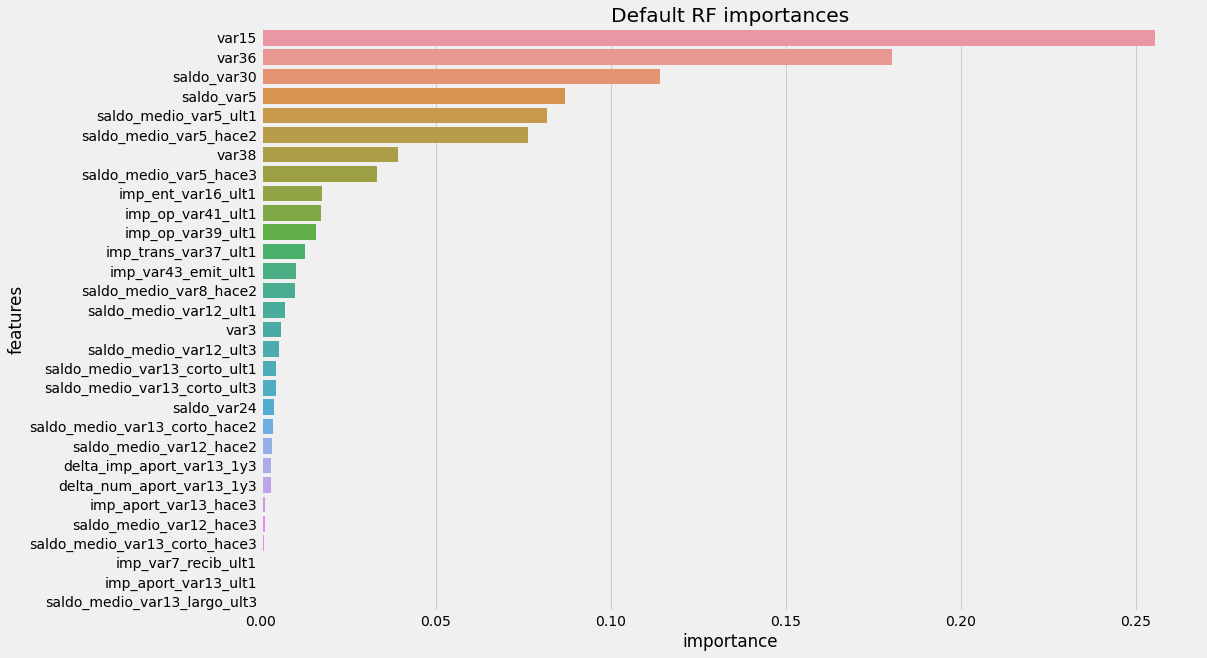

In [24]:
plot_importance(Xtrain_lasso.columns, rf.feature_importances_, top=30, title="Default RF importances")

When we do default RandomForest Importances we see that as many as 5 variablse have high importance. But as we know Default tree importances can often be misleading so we'll also try permutation importance.

In [25]:
Val_data = Xval_lasso.copy()
Val_data['target'] = yval

Val_data = Val_data.sample(frac=.1)

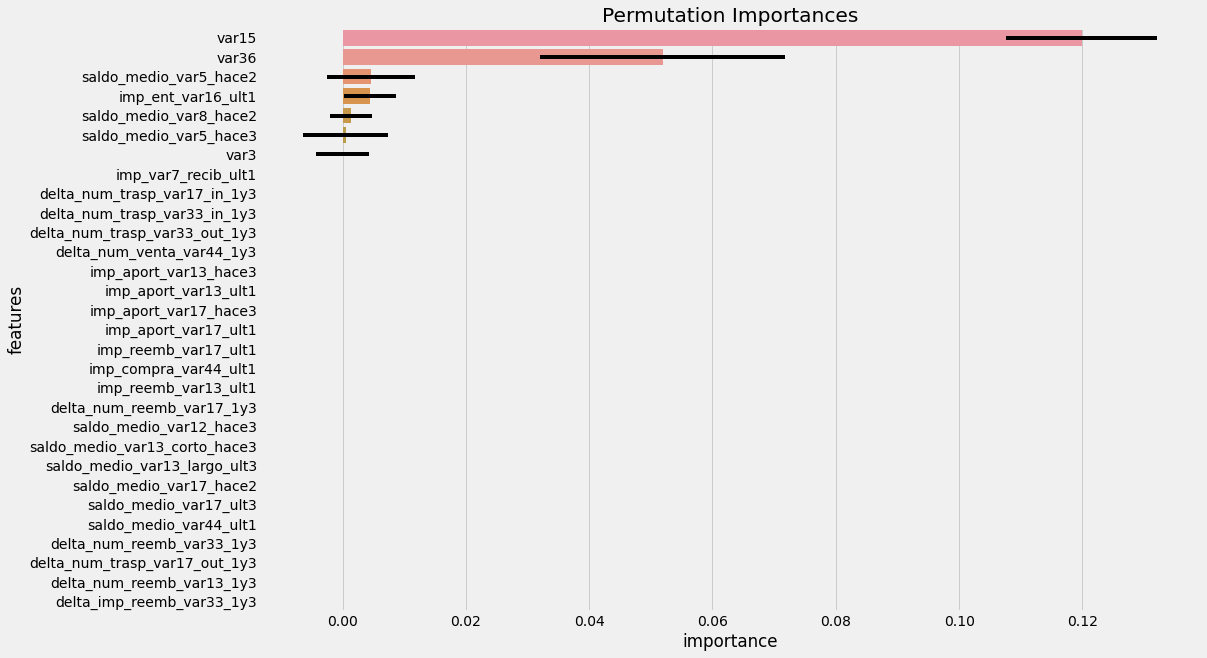

In [26]:
rf_perm = permutation_importance(rf, Val_data.drop('target', axis=1), Val_data.target,
                                 n_jobs=-1,
                                 scoring='f1')

df=plot_importance(Xtrain_lasso.columns, rf_perm['importances_mean'], top=30,
                title="Permutation Importances", fistd=rf_perm['importances_std'],
                return_df=True)

A lot of important features (as suggested by RF default importance) vanish in Permutation importance plot. Var15 and Var36 have high importance than other variables.

### PDP Plots

In [27]:
top_features = df.features.tolist()[:9]
top_features

['var15',
 'var36',
 'saldo_medio_var5_hace2',
 'imp_ent_var16_ult1',
 'saldo_medio_var8_hace2',
 'saldo_medio_var5_hace3',
 'var3',
 'imp_var7_recib_ult1',
 'delta_num_trasp_var17_in_1y3']

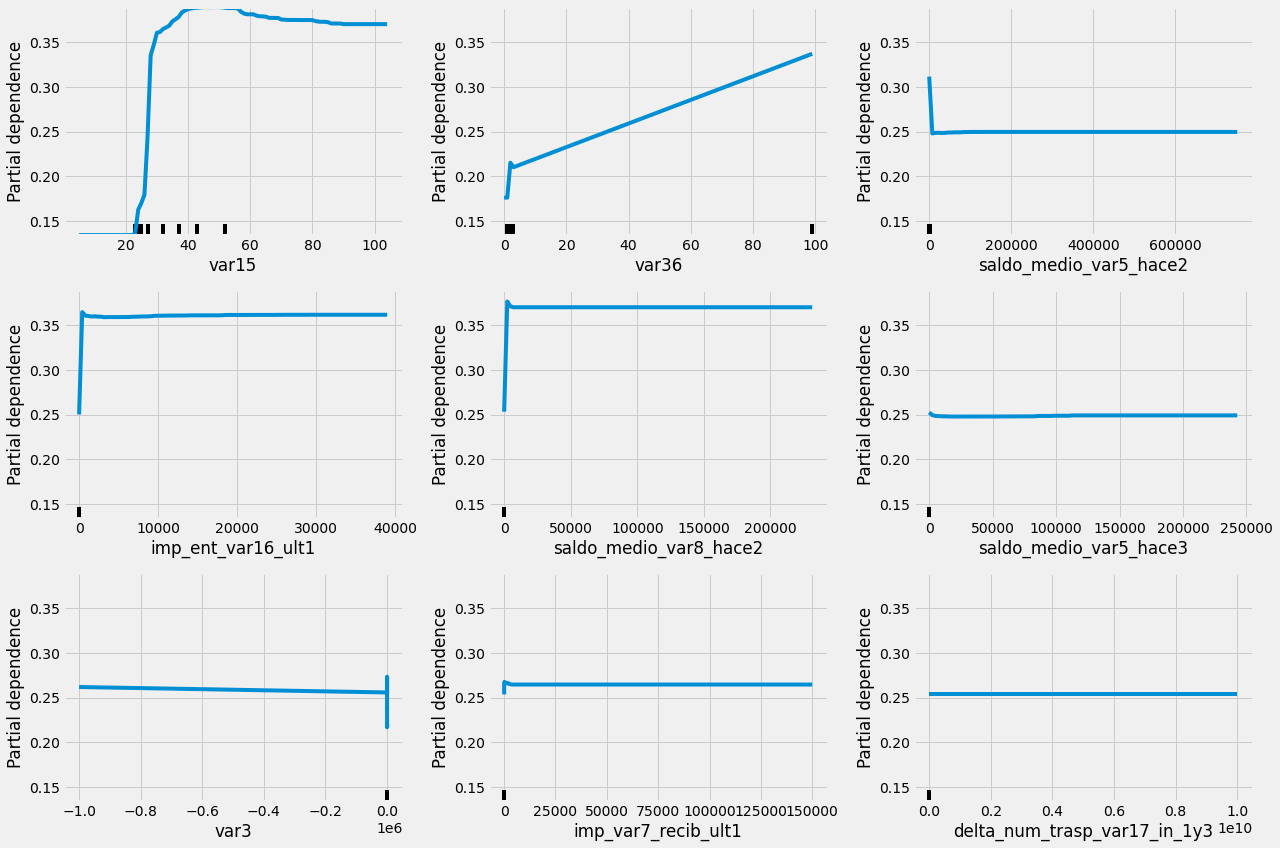

In [28]:
fig, ax = plt.subplots(3,3,figsize=(18,12))
ax=ax.ravel()
plot_partial_dependence(rf, Xval_lasso, top_features, ax=ax, percentiles=(0, 1), n_jobs=-1)
fig.tight_layout()

When we do PDP plots for top 9 features according to permutation importance we see that flat graphs for most. This is due to 0 inflation in most columns. We see a increasing trend in graph for var36. For var15 graph rises for a while and then plateaus.

## Conclusion


We studied Santander Customer Satisfaction dataset.

We observed a lot of features we either constant or quasi-constant. 

We dealt with correlations using Lasso Path.

When a non-trivial model was trained on around 70 features selected by Lasso path it outperformed other model trained on all 369 features.

We beat Baseline F-1 score by a small margin.

We plotted various ROC curves and our best AUC score was .82.

We plotted importances using RandomForest's default importances and Permuatation Importances.

A lot of features which were tagged as important by RFI were found not very important in permutation importance's graph.

Due to very high 0 inflation in almost all features PDPs may not be very accurate.

